In [2]:
import nltk
import numpy as np
import pandas as pd
import sklearn 
import string
from nltk import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package words to C:\Users\Umair
[nltk_data]     Akhtar\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Umair
[nltk_data]     Akhtar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Umair
[nltk_data]     Akhtar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv("mod.csv")
df = df.drop(df.columns[0], axis=1)
df

,sentiment,text
0,positive,"Thank you, Ellen. We have a strong 2018, with ..."
1,positive,Stock-based compensation totaled $2.3 billion....
2,neutral,"For opening remarks, I will be turning the cal..."
3,positive,[Operator Instructions]. Our first question wi...
4,positive,"Hey, thanks. So I guess the question I have an..."
5,positive,I'll take that one Karen. Well obviously a lot...
6,neutral,"And with that said and Gary mentioned it, we w..."
7,negative,"Okay, and I guess just a follow-up then, so if..."
8,neutral,"Hi, this is Gary. I think we feel as I mention..."
9,positive,I do think that as we head through 2019 and we...


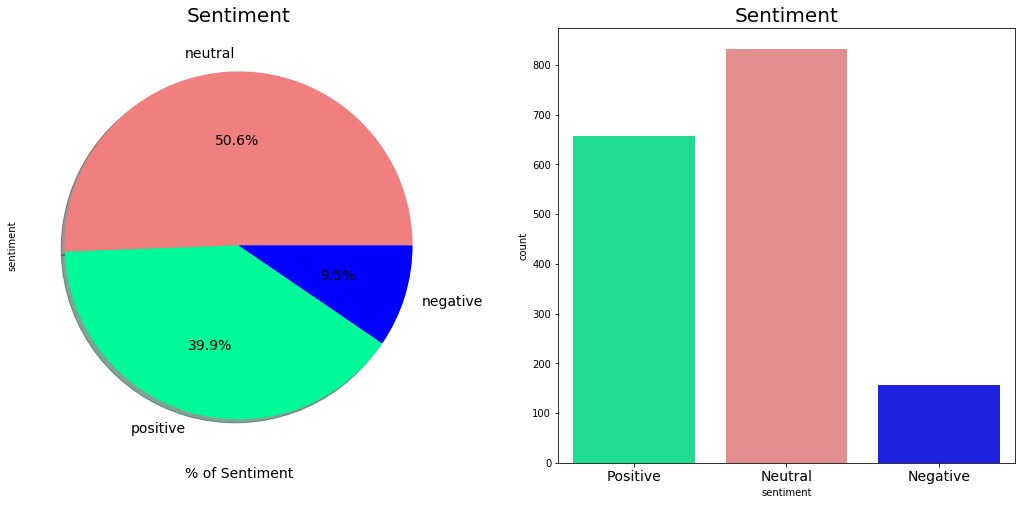

In [4]:
subscribed = df.sentiment
f,ax=plt.subplots(1,2,figsize=(18,8))
colors=["#F08080", "#00FA9A", "Blue"]
# labels = 'Refused a T.D. Suscription', 'Accepted a T.D. Suscription'
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True, colors=colors,fontsize=14)
ax[0].set_title('Sentiment', fontsize=20)
ax[0].set_xlabel('% of Sentiment', fontsize=14)
colors=[ "#00FA9A","#F08080", "Blue"]
sns.countplot('sentiment',data=df,ax=ax[1], palette=colors)
ax[1].set_title('Sentiment', fontsize=20)
ax[1].set_xticklabels(['Positive', 'Neutral','Negative'], fontsize=14)
plt.show()

The data imbalance is pretty clear from given plots. I will use couple of methods to tackle this issue.

In [5]:
df = df.dropna()

### Let's visualize the data

In [6]:
df.head(5)

,sentiment,text
0,positive,"Thank you, Ellen. We have a strong 2018, with ..."
1,positive,Stock-based compensation totaled $2.3 billion....
2,neutral,"For opening remarks, I will be turning the cal..."
3,positive,[Operator Instructions]. Our first question wi...
4,positive,"Hey, thanks. So I guess the question I have an..."


In [7]:
X = df['text']
y = df['sentiment']

In [83]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y

array([2, 2, 1, ..., 1, 1, 1])

In [9]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
data = []
en_stop = set(nltk.corpus.stopwords.words('english'))
words = set(nltk.corpus.words.words())
for i,x in enumerate(X):
    tokens = word_tokenize(x)
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token for token in tokens if token in words]
    tokens = [token.lower() for token in tokens]
    print(i, len(tokens))
    data.append(tokens)
#     print(tokens)

0 13
1 22
2 8
3 5
4 59
5 88
6 12
7 20
8 47
9 36
10 22
11 81
12 76
13 24
14 60
15 31
16 55
17 48
18 3
19 31
20 48
21 12
22 27
23 34
24 24
25 43
26 3
27 28
28 58
29 47
30 12
31 4
32 69
33 36
34 65
35 12
36 42
37 3
38 3
39 46
40 42
41 24
42 19
43 17
44 1
45 39
46 26
47 59
48 1
49 5
50 12
51 3
52 4
53 4
54 21
55 27
56 2
57 15
58 1
59 5
60 5
61 8
62 26
63 17
64 90
65 6
66 3
67 3
68 21
69 17
70 34
71 26
72 87
73 2
74 28
75 59
76 38
77 6
78 3
79 36
80 0
81 3
82 1
83 0
84 1
85 0
86 1
87 0
88 2
89 1
90 18
91 3
92 1
93 2
94 3
95 2
96 0
97 1
98 0
99 14
100 3
101 26
102 2
103 27
104 17
105 2
106 0
107 22
108 45
109 29
110 19
111 21
112 18
113 30
114 31
115 43
116 27
117 26
118 47
119 50
120 14
121 20
122 49
123 24
124 53
125 28
126 41
127 30
128 13
129 6
130 0
131 31
132 31
133 23
134 21
135 7
136 38
137 30
138 16
139 55
140 30
141 29
142 59
143 22
144 28
145 23
146 33
147 22
148 31
149 24
150 54
151 64
152 64
153 27
154 13
155 35
156 14
157 18
158 31
159 26
160 43
161 27
162 20
163 5
164 1
165 0


1328 11
1329 4
1330 7
1331 3
1332 1
1333 22
1334 29
1335 21
1336 15
1337 102
1338 18
1339 32
1340 13
1341 8
1342 4
1343 4
1344 17
1345 6
1346 17
1347 12
1348 53
1349 25
1350 18
1351 26
1352 17
1353 16
1354 21
1355 24
1356 13
1357 1
1358 3
1359 44
1360 1
1361 6
1362 4
1363 18
1364 9
1365 24
1366 32
1367 23
1368 9
1369 21
1370 28
1371 17
1372 12
1373 16
1374 4
1375 2
1376 11
1377 7
1378 17
1379 19
1380 23
1381 49
1382 25
1383 17
1384 13
1385 16
1386 4
1387 3
1388 28
1389 13
1390 21
1391 4
1392 28
1393 5
1394 39
1395 5
1396 25
1397 18
1398 19
1399 31
1400 32
1401 17
1402 4
1403 26
1404 30
1405 2
1406 32
1407 22
1408 6
1409 12
1410 23
1411 4
1412 4
1413 15
1414 8
1415 27
1416 30
1417 16
1418 24
1419 3
1420 5
1421 19
1422 20
1423 18
1424 14
1425 5
1426 39
1427 5
1428 24
1429 17
1430 22
1431 18
1432 22
1433 3
1434 4
1435 18
1436 22
1437 8
1438 14
1439 10
1440 5
1441 6
1442 22
1443 9
1444 21
1445 13
1446 4
1447 4
1448 30
1449 31
1450 6
1451 27
1452 25
1453 9
1454 17
1455 20
1456 16
1457 5
145

In [96]:
finalData = []
for token in data:
    finalData.append(' '.join(token))
print(finalData)
# print(data)

['thank strong total billion reflect benefit invest except user compel return partner custom', 'total billion end quarter last quarter consist prior quarter major new hire product term product area head count cloud technic sale role', 'open remark turn call director investor go ahead', 'instruct first question come short', 'hey thank guess question know tri us look term core fuel altern profit kind give us slide analyst day depict hard look way look full year tri break core actual fair like kind back almost quarter guess help understand second part would ask obvious tri think way think mean growth need core credit growth color attain guess grow core', 'take one well obvious lot made lot invest affect wide differ line difficult say obvious fuel good quarter good year look tri back core digit invest digit back put grow new yes would drive core way look digit invest made along invest made fourth quarter talk new open support digit look core yes core wo go number slice dice said would look

In [97]:
# print(len(finalData), len(y))
X_data = np.array(finalData)
# y_data = np.array(y)
print(X_data.shape, y.shape)

(1643,) (1643,)


In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=123, stratify=y)

### BOW Model

In [116]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
nb_clf_1 = Pipeline([('vect', CountVectorizer()),('clf', MultinomialNB())])
nb_clf_1 = nb_clf_1.fit(X_train,y_train)
print('Training Accuracy: ',nb_clf_1.score(X_train,y_train))
print('Validation Accuracy: ',nb_clf_1.score(X_test,y_test))

Training Accuracy:  0.7678843226788432
Validation Accuracy:  0.5379939209726444


In [117]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb_clf_1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.33      0.03      0.06        32
           1       0.57      0.68      0.62       166
           2       0.50      0.48      0.49       131

   micro avg       0.54      0.54      0.54       329
   macro avg       0.47      0.40      0.39       329
weighted avg       0.52      0.54      0.51       329



In [118]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, nb_clf_1.predict(X_train))

array([[ 50,  57,  18],
       [  3, 604,  58],
       [  2, 167, 355]], dtype=int64)

#### BOW + TFIDF

In [119]:
nb_clf_2 = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])
nb_clf_2 = nb_clf_2.fit(X_train,y_train)
print('Training Accuracy: ',nb_clf_2.score(X_train,y_train))
print('Validation Accuracy: ',nb_clf_2.score(X_test,y_test))

Training Accuracy:  0.7176560121765602
Validation Accuracy:  0.5531914893617021


In [122]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb_clf_2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.56      0.78      0.65       166
           2       0.54      0.40      0.46       131

   micro avg       0.55      0.55      0.55       329
   macro avg       0.37      0.39      0.37       329
weighted avg       0.50      0.55      0.51       329



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [123]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, nb_clf_2.predict(X_train))

array([[  1,  96,  28],
       [  0, 632,  33],
       [  0, 214, 310]], dtype=int64)

#### BOW + LR

In [129]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(X_data)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(bow, y, test_size=0.2, random_state=123, stratify=y)


model = LogisticRegression(random_state=21, multi_class='ovr', class_weight='balanced')
model.fit(X_train_bow, y_train)
y_pred_train = model.predict(X_train_bow)
f1_score(y_train, np.asarray(y_pred_train), average='weighted')



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8727270774962301

In [130]:
y_pred_test = model.predict(X_test_bow)
f1_score(y_test, np.asarray(y_pred_test), average='weighted')

0.4813250458996789